# SVM for Email Spam Attacks

In [394]:
%matplotlib inline
# Preamble
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md

from math import *

import datetime
from dateutil.parser import parse
import collections
import math
import time
import os
import subprocess

import graphviz as gv
import hashlib
import pickle

import networkx as nx
from networkx.algorithms import isomorphism
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph

from sklearn.metrics import confusion_matrix

spam_attackers = ["42.219.156.212", "42.219.156.213", "42.219.156.214", "42.219.156.215", "42.219.156.223"]

In [4]:
def openPickle(sup):
    return pickle.load(open("pickles/2016-06-20_5min_"+'s_'+str(sup).replace('.','_')+'.p', 'rb'))

FIM_groups_0_1 = openPickle(0.1)
FIM_groups_0_05 = openPickle(0.05)
FIM_groups_0_025 = openPickle(0.025)

In [432]:
def graphFromFIM(fim):
    G = nx.Graph()
    counter = 0
    for items, sup in fim.items():
        nodes = ["ip:"+i[3:] if i.startswith('sa') or i.startswith('da') else i
                for i in list(items)]
        G.add_nodes_from(nodes, color='b')
        
        G.add_edges_from([(node, str(counter)) for node in nodes], weight=sup)
        counter += 1
    return G

def emailGraph(G):
    if not G.has_node('sp:25'):
        return None
    e_g = nx.ego_graph(G, 'sp:25', 4)
    for ip in spam_attackers:
            if e_g.has_node("ip:"+ip):
                e_g.add_node("ip:"+ip, color='pink',style='filled')
    return e_g

def emailGraphsFromFIMGroup(fg): return {l:emailGraph(graphFromFIM(f)) for l,f in fg.items()}
def draw(g): nx.draw(g, with_labels=True, prog='sfdp')

In [433]:
email_graphs1 = emailGraphsFromFIMGroup(FIM_groups_0_1)
email_graphs2 = emailGraphsFromFIMGroup(FIM_groups_0_05)
email_graphs3 = emailGraphsFromFIMGroup(FIM_groups_0_025)

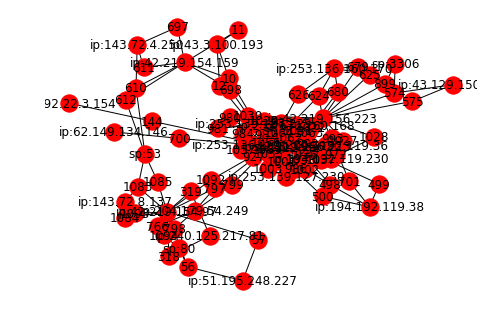

In [440]:
g = email_graphs3[datetime.datetime(2016, 6, 20, 22, 30)]
draw(g)

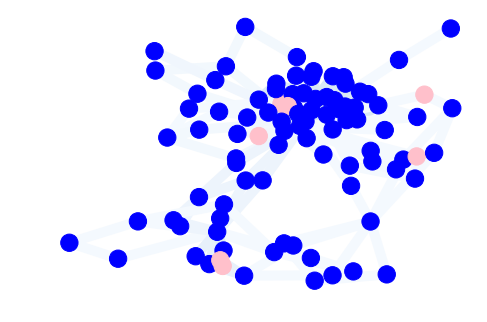

In [446]:
pos = nx.spring_layout(g)
edges, weights = zip(*nx.get_edge_attributes(g,'weight').items())
weights = [w/max(weights) for w in weights]
nodes, node_col = zip(*nx.get_node_attributes(g,'color').items())
nx.draw(g, pos, node_color=node_col, edgelist=edges, edge_color=weights, 
        width=10.0, edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1)

In [445]:
nx.get_node_attributes(g,'color')

{'ip:143.72.4.250': 'b',
 'ip:143.72.8.137': 'b',
 'ip:192.22.3.154': 'b',
 'ip:194.192.119.230': 'b',
 'ip:194.192.119.36': 'b',
 'ip:194.192.119.38': 'b',
 'ip:204.179.54.249': 'b',
 'ip:240.125.217.81': 'b',
 'ip:253.136.160.168': 'b',
 'ip:253.136.160.170': 'b',
 'ip:253.136.161.200': 'b',
 'ip:253.139.127.229': 'b',
 'ip:253.139.127.230': 'b',
 'ip:42.219.154.159': 'b',
 'ip:42.219.154.97': 'b',
 'ip:42.219.156.213': 'pink',
 'ip:42.219.156.223': 'pink',
 'ip:43.129.150.108': 'b',
 'ip:43.3.100.193': 'b',
 'ip:51.195.248.227': 'b',
 'ip:62.149.134.146': 'b',
 'sp:25': 'b',
 'sp:3306': 'b',
 'sp:53': 'b',
 'sp:80': 'b'}

In [358]:
# feature extraction
def avgDeg(G): return np.mean([G.degree(n) for n in G.nodes()])
def varDeg(G): return np.var([G.degree(n) for n in G.nodes()])
def degAssortCoef(G): 
    # degenerate case where all nodes have the same degree
    result = nx.degree_assortativity_coefficient(G)
    if math.isnan(result):
        return 0
    else:
        return result
def avgDistance(G): return nx.average_shortest_path_length(G)
def varDistance(G):
    p = nx.floyd_warshall(G)
    dists = [[ p[v2][v1] for j, v2 in enumerate(G.nodes())]
             for i, v1 in enumerate(G.nodes())]
    return np.var(dists)
def avgDistanceWeighted(G): return nx.average_shortest_path_length(G)
def varDistanceWeighted(G):
    p = nx.floyd_warshall(G)
    dists = [[ p[v2][v1] for j, v2 in enumerate(G.nodes())]
             for i, v1 in enumerate(G.nodes())]
    return np.var(dists)
# not defined for single components
def avgClustering(G): return np.mean([v for k,v in nx.clustering(G).items()])
# not used for now since may return complex numbers
def secondSmallestEigenValue(G):
    L = nx.normalized_laplacian_matrix(G)
    e = np.linalg.eigvals(L.A)
    e.sort()
    return e[1]

graphAllFeatures = {"avgDeg":avgDeg,"varDeg":varDeg,"degAssortCoef":degAssortCoef,
                "avgDistance":avgDistance,"varDistance":varDistance,"avgDistanceWeighted":avgDistanceWeighted,
                   "varDistanceWeighted":varDistanceWeighted}
graphFeatures = [(k,v) for k,v in graphAllFeatures.items()]
# np array
def normalize(ll): return ll/max(ll)

def timeLabels(FIM_graphs):
    return [l for l,g in FIM_graphs.items() if g is not None]
def featureDataSeries(FIM_graphs, f, norm=False):
    data = [f(g) for l,g in FIM_graphs.items() if g is not None]
    if norm:
        return normalize(np.array(data))
    else:
        return np.array(data)

In [363]:
def plotTimeSeries(emailGraphs, F):
    tLabels = timeLabels(emailGraphs)
    
    fig = plt.figure(figsize=(18, 15))
    ax =fig.add_subplot(111)
    xfmt = md.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    
    for t in F:
        l, f = t
        data = featureDataSeries(emailGraphs, f, True)
        ax.plot(tLabels, data, label=l)
    ax.legend()
    return ax, fig

/usr/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbd6347d160>,
 <matplotlib.figure.Figure at 0x7fbd5bbc2438>)

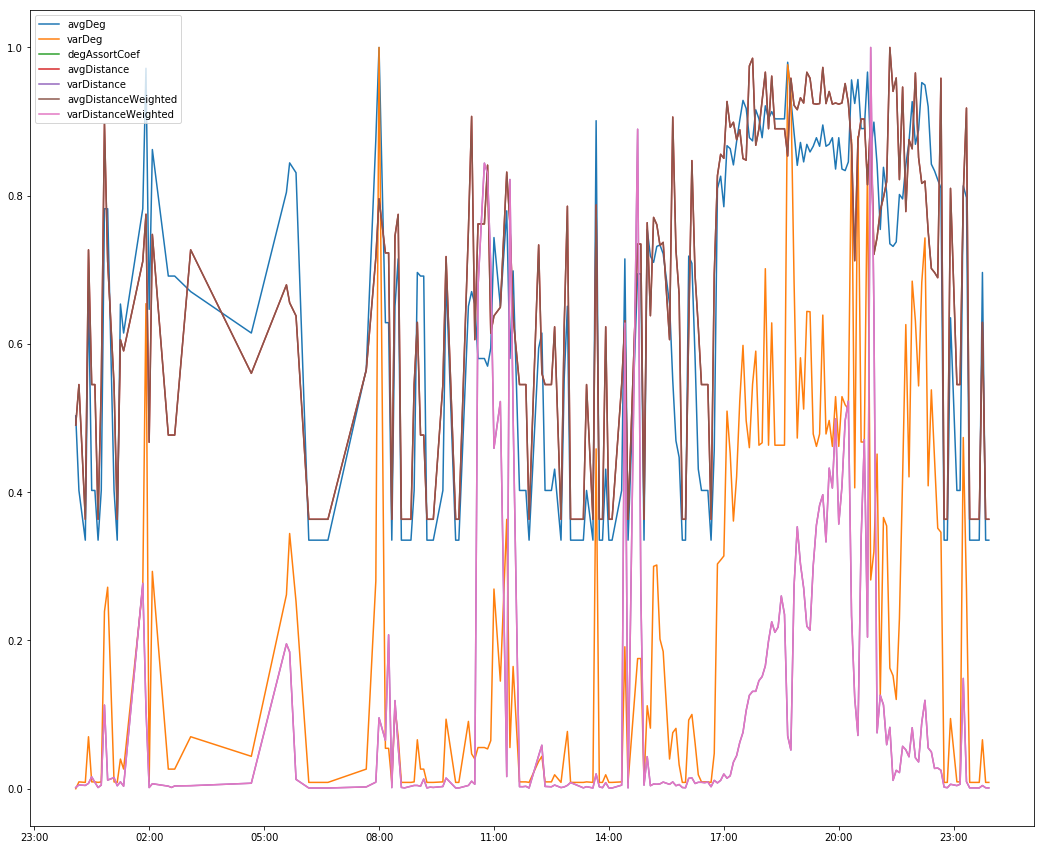

In [364]:
plotTimeSeries(email_graphs1, graphFeatures)

In [409]:
# plot ego graphs
def graphFromFIM(fim):
    G = nx.Graph()
    counter = 0
    for items, sup in fim.items():
        nodes = ["ip:"+i[3:] if i.startswith('sa') or i.startswith('da') else i
                for i in list(items)]
        G.add_nodes_from(nodes)
        G.add_edges_from([(node, str(counter)) for node in nodes], weight=sup)
        counter += 1        
    return G

for l, fim in FIM_group_cross.items():
    graph = graphFromFIM(fim)
    e = emailGraph(graph)
    if e is not None:
        g = to_agraph(e)
        g.draw('images/UGDS/2016-06-21_5min_email_ego3/'+str(l)+'.png', prog='sfdp')

## SVM

### Extracting Anomaly Timepoints

In [330]:
#####
# Anomaly I/O stuff
#####

# WARMING: long operation
def setIndexAsTime(df, width):
    _index = [datetime.datetime.fromtimestamp(i * width) for i in df.index]
    df.index = _index
    return df

def readAndTimeBin(filename, col, selectedFeatures, width = 60):
    df = pd.read_csv(filename)
    df['timebin'] = df.apply (lambda row: createTimebin(row, width, col),axis=1)
    df = df[['timebin'] + selectedFeatures]
    # df = setIndexAsTime(df, width)
    return df

def createTimebin(row, timeWidth, col):
    d = parse(row[col])
    return int(d.timestamp() // timeWidth)

def aggByMax(df):
    grouped = df.groupby('timebin')
    return grouped.agg('max')

def readAnomalyFile(filename, width):
    anom_features = ["anomaly-spam"]
    df_anomaly = readAndTimeBin(filename, 'time', anom_features, width)
    df_anomaly = aggByMax(df_anomaly)
    df_anomaly = setIndexAsTime(df_anomaly, width)
    return df_anomaly

In [331]:
width = 5 * 60 # 5 minutes
df_anom = readAnomalyFile("data/2016-06-20_spam.csv", width)
df_anom.head()

,anomaly-spam
2016-06-20 12:10:00,1
2016-06-20 12:35:00,1
2016-06-20 12:45:00,1
2016-06-20 13:20:00,1
2016-06-20 13:25:00,1


In [405]:
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import accuracy_score
from sklearn import svm

def computePoints(email_graphs, F):
    labels = [l for l, g in email_graphs.items() if g is not None]
    streams = [ minmax_scale([f(email_graphs[l]) for l in labels]) for f_name, f in F]
    points = list(map(list, zip(*streams)))
    assert len(points) == len(labels)
    return {k:v for k,v in zip(labels, points)}

def labelPoints(points, df_anom):
    '''
    points: dict of timestamp to point
    '''
    attack_times = set(df_anom.index.tolist())
    labels = [l for l, p in points.items()]
    X = [p for l, p in points.items()]
    y_true = [1 if l in attack_times else 0 for l, p in points.items()]
    return (labels, X, y_true)

In [407]:
points = computePoints(email_graphs1, graphFeatures)
timeLabels, X, y_true = labelPoints(points, df_anom)

clf = svm.SVC()
clf.fit(X, y_true)
y_pred = [clf.predict([pt]) for pt in X]
accuracy_score(y_true, predicted, normalize=True)

/usr/lib/python3.6/site-packages/networkx/algorithms/assortativity/correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


0.7989690721649485

In [408]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
(tn, fp, fn, tp)

(79, 13, 26, 76)

In [382]:
print("anomaly points:",len(attack))
print("normal points:",len(norm))

anomaly points: 102
normal points: 92


In [ ]:
# look at the false positives

In [402]:
y = [1 for i in range(len(attack))] + [0 for i in range(len(norm))]
X = list(attack.values()) + list(norm.values()) 
clf = svm.SVC()
clf.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [370]:
predicted = [clf.predict([pt]) for pt in X]
accuracy_score(y, predicted, normalize=True)

0.7989690721649485

In [371]:
from pandas.plotting import scatter_matrix
def plotScatterPlot(norm, attack, F):
    cols = [f_name for f_name, f in F] + ['attack']
    arr = [v+[False] for v in norm.values()] + [v+[True] for v in attack.values()]
    y = [False for v in norm.values()] + [True for v in attack.values()]
    df = pd.DataFrame(arr,columns=cols)
    colors = np.where(df["attack"]==1,'r','b')
    scatter_matrix(df[cols[:-1]], alpha=0.1, c=colors,figsize=(16, 16), diagonal='kde')

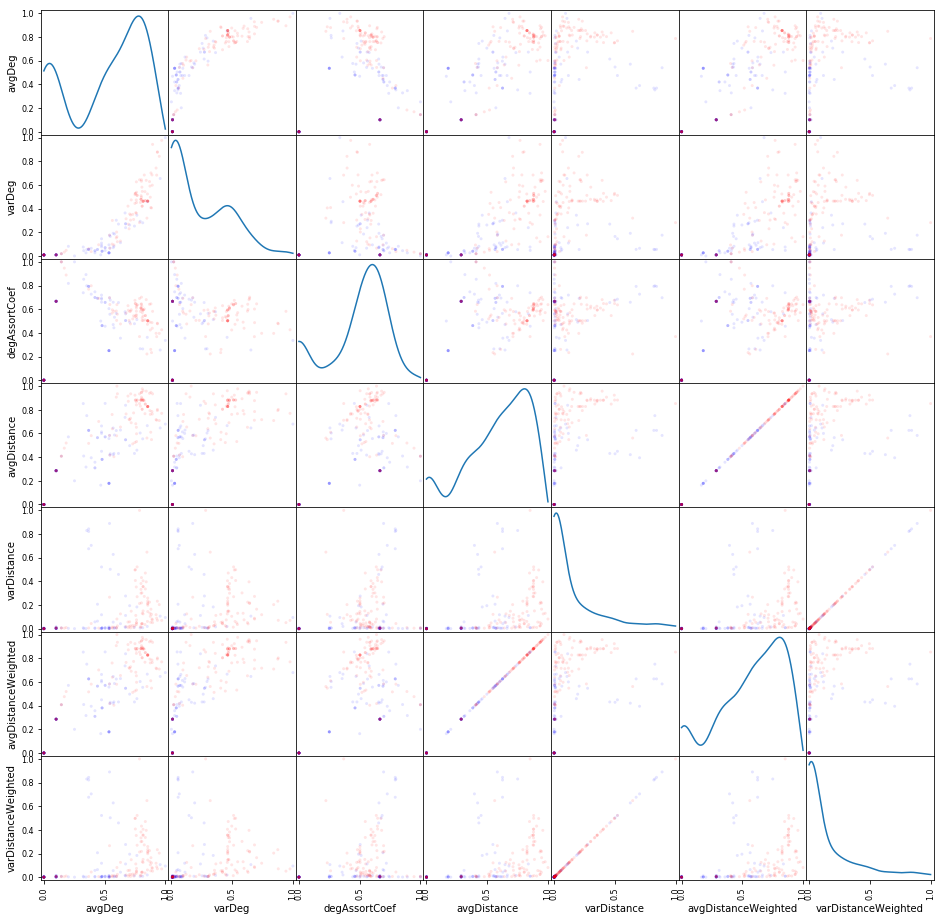

In [368]:
# without weight
plotScatterPlot(norm, attack, graphFeatures)

# Cross Validation

Cross validate with data the next day

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbd60f97438>,
 <matplotlib.figure.Figure at 0x7fbd62c1b780>)

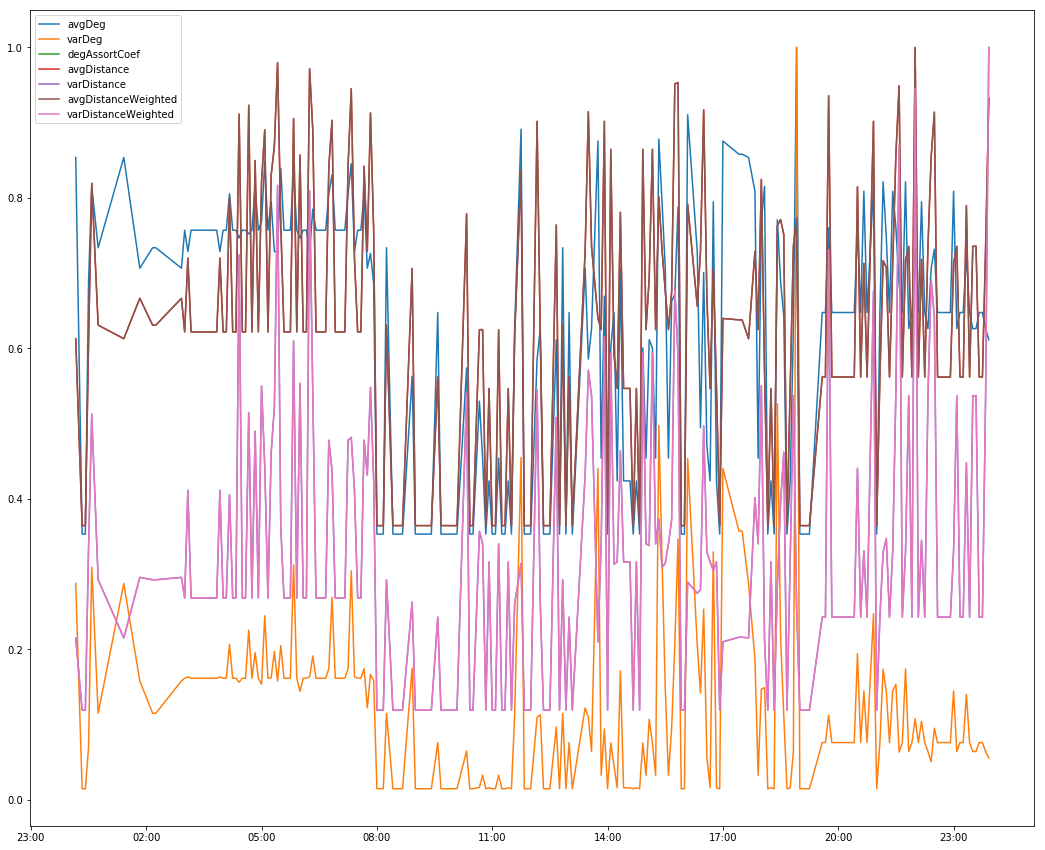

In [378]:
df_anom_cross = readAnomalyFile("data/2016-06-21_spam.csv", width)
FIM_group_cross = pickle.load(open("pickles/2016-06-21_5min_s_0_1.p", 'rb'))
email_graphs_cross = emailGraphsFromFIMGroup(FIM_group_cross)
plotTimeSeries(email_graphs_cross, graphFeatures)

In [384]:
df_anom_cross

,anomaly-spam
2016-06-21 00:00:00,1
2016-06-21 00:05:00,1
2016-06-21 00:10:00,1
2016-06-21 00:15:00,1
2016-06-21 00:20:00,1
2016-06-21 00:25:00,1
2016-06-21 00:30:00,1
2016-06-21 00:35:00,1
2016-06-21 00:40:00,1
2016-06-21 00:50:00,1


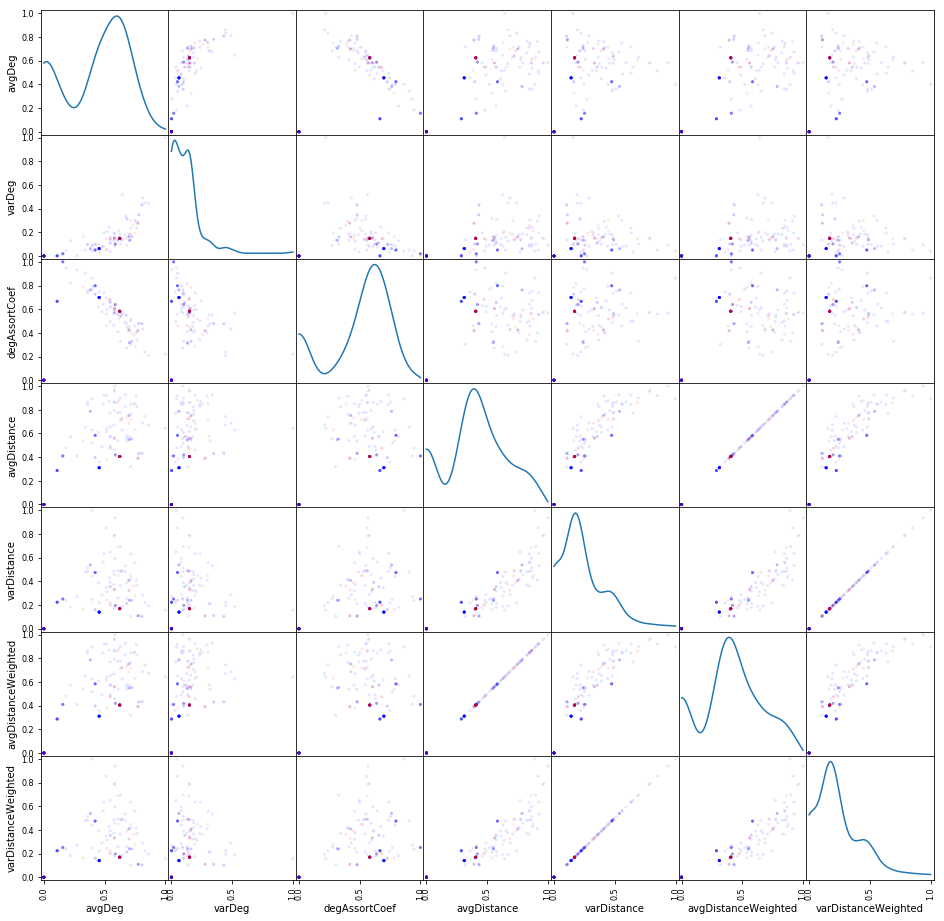

In [381]:
plotScatterPlot(norm_cross, attack_cross, graphFeatures)

In [383]:
norm_cross, attack_cross = classifyPoints(computePoints(email_graphs_cross, graphFeatures), df_anom_cross)
print("anomaly points:",len(attack_cross))
print("normal points:",len(norm_cross))

anomaly points: 36
normal points: 193


In [387]:
def crossValidation(fiM_group, df_anom, clf):
    email_graphs_cross = emailGraphsFromFIMGroup(fiM_group)
    norm_cross, attack_cross = classifyPoints(computePoints(email_graphs_cross, graphFeatures), df_anom)
    y_true = [1 for i in range(len(attack_cross))] + [0 for i in range(len(norm_cross))]
    X_cross = list(attack_cross.values()) + list(norm_cross.values()) 
    y_pred = [clf.predict([pt]) for pt in X_cross]
    score = accuracy_score(y_true, y_pred, normalize=True)
    return (y_true, y_pred, score)

# tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

In [389]:
t, p, score = crossValidation(FIM_group_cross, df_anmm_cross, clf)
print(score)

0.755458515284


In [396]:
tn, fp, fn, tp = confusion_matrix(t, p).ravel()
(tn, fp, fn, tp)

(164, 29, 27, 9)

There are no attacks on the 22th and 23rd of June.

In [375]:
FIM_group_cross2 = pickle.load(open("pickles/2016-06-22_5min_s_0_1.p", 'rb'))
p2, score2 = crossValidation(FIM_group_cross2, pd.DataFrame(), clf)

In [376]:
print(score2)

0.7625


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbd615ec828>,
 <matplotlib.figure.Figure at 0x7fbd60dd6a58>)

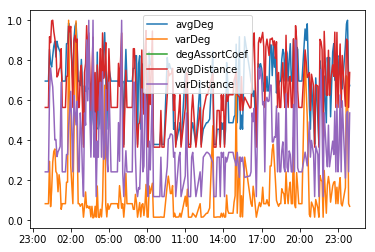

In [289]:
plotTimeSeries(emailGraphsFromFIMGroup(FIM_group_cross2), graphFeatures)